<br></br>
# **나이브베이즈 한글 적용**
네이버 영화리뷰 데이터 활용
1. 0 : 부정적인 리뷰
1. 1 : 긍정적인 리뷰

<br></br>
## **1 NAVER 영화리뷰 데이터 전처리**
1. https://github.com/e9t/nsmc
1. https://www.nltk.org/book/ch06.html

In [1]:
! cat ./data/ratings_test.txt | head -n 10

id	document	label
6270596	굳 ㅋ	1
9274899	GDNTOPCLASSINTHECLUB	0
8544678	뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아	0
6825595	지루하지는 않은데 완전 막장임... 돈주고 보기에는....	0
6723715	3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??	0
7898805	음악이 주가 된, 최고의 음악영화	1
6315043	진정한 쓰레기	0
6097171	마치 미국애니에서 튀어나온듯한 창의력없는 로봇디자인부터가,고개를 젖게한다	0
8932678	갈수록 개판되가는 중국영화 유치하고 내용없음 폼잡다 끝남 말도안되는 무기에 유치한cg남무 아 그립다 동사서독같은 영화가 이건 3류아류작이다	0
cat: 쓰기 오류: 파이프가 깨어짐


In [2]:
def read_data(filename):
    with open(filename, 'r') as f:
        data = [line.split('\t') for line in f.read().splitlines()]
        data = data[1:]   # header 제외
        
    from random import randint
    random_data = [data[randint(1, len(data))]  for no in range(int(len(data)/50)) ]
    return random_data

train_data = read_data('./data/ratings_train.txt')
test_data  = read_data('./data/ratings_test.txt')
print('Train_data : {}\nsample     : {}'.format(len(train_data), train_data[:3]))
print('Test_data  : {}\nsample     : {}'.format(len(test_data),  test_data[:3]))

Train_data : 3000
sample     : [['9868047', '너무 느려뜨리는 구성 재미는 약간', '0'], ['3566519', '아버지의 눈동자가 잊혀지지 않는다.', '1'], ['10248836', '이영화 정말 난 모르겠다 쓸말도 없다', '0']]
Test_data  : 1000
sample     : [['4785647', '아동용 만화란걸 보고나서 알았습니다. ㅡㅡ 평점믿고 봤더니 낭패', '0'], ['7777543', '정말 해도해도 심함 다이빙 지겹다 지겹단말은 재미없단뜻이죠!!!영영 보지 말아야겟음 발전없는 에스비에스 예능', '0'], ['7928602', '전채적 분위기는 어수선했고 홍보는 실컷 승리 팔아먹더니 정작 클라라 특집. 아니 40분을 한사람한테 몰아주는게말이냐고요. 컴백한 가수한테 앨범얘기는 안하고 스캔들만 얘기하더니 초반 한명 빼고는 다 시간에 쫓겨서 허덕이고 뒤에 개그맨 두분은 병풍입니까?', '0']]


In [3]:
%%time
from konlpy.tag import Okt
pos_tagger = Okt()

def tokenize(doc):
    result = ['/'.join(t) for t in pos_tagger.pos(doc, norm=True, stem=True)]
    return result 

train_docs = [(tokenize(row[1]), row[2])    for row in train_data]
test_docs  = [(tokenize(row[1]), row[2])    for row in test_data]

from pprint import pprint
pprint(train_docs[:2])

[(['너무/Adverb',
   '느리다/Adjective',
   '뜨다/Verb',
   '리/Noun',
   '는/Josa',
   '구성/Noun',
   '재미/Noun',
   '는/Josa',
   '약간/Noun'],
  '0'),
 (['아버지/Noun',
   '의/Josa',
   '눈동자/Noun',
   '가/Josa',
   '잊혀지다/Verb',
   '않다/Verb',
   './Punctuation'],
  '1')]
CPU times: user 24.7 s, sys: 460 ms, total: 25.2 s
Wall time: 14.5 s


In [4]:
tokens = [t   for d in train_docs 
              for t in d[0]]
print("Token Total :{}\nSample : {}".format(
    len(tokens), tokens[:5]))

Token Total :43237
Sample : ['너무/Adverb', '느리다/Adjective', '뜨다/Verb', '리/Noun', '는/Josa']


<br></br>
## **2 nltk 를 활용하여 연산모델 만들기**
https://github.com/e9t/nsmc

In [5]:
import nltk
text = nltk.Text(tokens, name='NMSC')

print("number of Token : {} \nunique Token    : {}\n".format(
    len(text.tokens), len(set(text.tokens))))
pprint(text.vocab().most_common(5))    

number of Token : 43237 
unique Token    : 6911

[('./Punctuation', 1327),
 ('영화/Noun', 996),
 ('하다/Verb', 854),
 ('보다/Verb', 774),
 ('이/Josa', 757)]


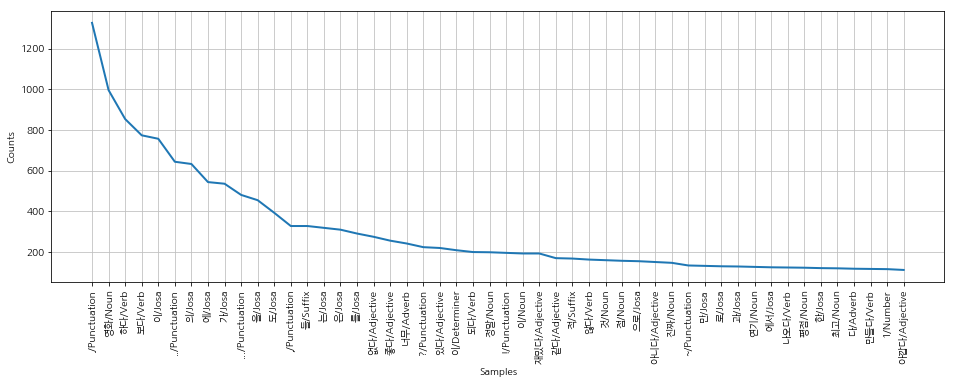

In [6]:
%matplotlib inline
from matplotlib import rc
rc('font', family='NanumGothic')

import matplotlib.pyplot as plt
plt.figure(figsize=(16,5))
text.plot(50) 

<br></br>
## **3 모델의 정확도/ 일반화를 높이는 추가작업**
우도 상위 4000개 데이터를 추출

In [8]:
selected_words = [f[0] for f in text.vocab().most_common(4000)]
selected_words[:5]

['./Punctuation', '영화/Noun', '하다/Verb', '보다/Verb', '이/Josa']

In [9]:
%%time
def term_exists(doc):
    return {'exists({})'.format(word): (word in set(doc)) for word in selected_words}

train_docs = train_docs[:10000]
train_xy   = [(term_exists(d), c) for d, c in train_docs]
test_xy    = [(term_exists(d), c) for d, c in test_docs]

CPU times: user 14.1 s, sys: 596 ms, total: 14.7 s
Wall time: 14.7 s


In [10]:
%%time
classifiers = nltk.NaiveBayesClassifier.train(train_xy)

CPU times: user 14.7 s, sys: 7.84 ms, total: 14.8 s
Wall time: 14.7 s


<br></br>
## **4 생성한 모델을 평가**
Accuracy
1. 0 : 부정리뷰
1. 1 : 긍정리뷰

In [11]:
classifiers.labels()

['0', '1']

In [18]:
classifiers.show_most_informative_features(15)

Most Informative Features
        exists(쓰레기/Noun) = True                0 : 1      =     41.1 : 1.0
          exists(냐/Josa) = True                0 : 1      =     17.3 : 1.0
   exists(아깝다/Adjective) = True                0 : 1      =     15.9 : 1.0
         exists(눈물/Noun) = True                1 : 0      =     13.4 : 1.0
        exists(차라리/Noun) = True                0 : 1      =     12.6 : 1.0
   exists(더럽다/Adjective) = True                0 : 1      =     11.9 : 1.0
  exists(아름답다/Adjective) = True                1 : 0      =     11.6 : 1.0
          exists(돈/Noun) = True                0 : 1      =     11.2 : 1.0
  exists(짜증나다/Adjective) = True                0 : 1      =     11.2 : 1.0
         exists(최고/Noun) = True                1 : 0      =     10.9 : 1.0
          exists(짱/Noun) = True                1 : 0      =     10.8 : 1.0
  exists(재미있다/Adjective) = True                1 : 0      =     10.6 : 1.0
        exists(0/Number) = True                0 : 1      =     10.5 : 1.0

In [13]:
%%time
'네이버 긍부정 모델의 Accuracy : {}'.format(
    nltk.classify.accuracy(classifiers, test_xy))

CPU times: user 10.1 s, sys: 7.9 ms, total: 10.2 s
Wall time: 10.2 s


'네이버 긍부정 모델의 Accuracy : 0.805'

<br></br>
## **5 모델의 활용**
1. 0 : 부정리뷰
1. 1 : 긍정리뷰

In [14]:
review = """영화가 졸잼 굿"""

In [15]:
review = tokenize(review)    # 문법 Tag 추가한 객체로 변환
review

['영화/Noun', '가/Josa', '졸잼/Noun', '굿/Noun']

In [16]:
review = term_exists(review) # 기준 용어들이 포함여부 판단
for k, v in review.items():
    if v == True:
        print("{} = {}".format(k, v))

exists(영화/Noun) = True
exists(가/Josa) = True
exists(굿/Noun) = True
exists(졸잼/Noun) = True


In [17]:
classifiers.classify(review)  # 분류모델 평가

'1'